## 4 Problem: Classifying Sneakers versus Sandals
### 4.1 Summarising the datasets
#### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit as sigmoid

#### D1 Print the number of instances

In [2]:
# Read the FMNIST training set and labels CSV file
train_labels = pd.read_csv('FMNIST_training_set_labels.csv', header=None, names=['label'])
train_set = pd.read_csv('FMNIST_training_set.csv', header=None)

# Read the FMNIST test set and labels CSV file
test_labels = pd.read_csv('FMNIST_test_set_labels.csv', header=None, names=['label'])
test_set = pd.read_csv('FMNIST_test_set.csv', header=None)

# Filter the set and labels to only include sneakers (7) and sandals (5)
ss_train_labels = train_labels[train_labels['label'].isin([5, 7])].copy()
ss_train_set = train_set[train_labels['label'].isin([5, 7])].copy()
ss_test_labels = test_labels[test_labels['label'].isin([5, 7])].copy()
ss_test_set = test_set[test_labels['label'].isin([5, 7])].copy()

# Replace the labels with 0 for sandals and 1 for sneakers
ss_train_labels['label'] = ss_train_labels['label'].replace({5: 1, 7: 0})
ss_test_labels['label'] = ss_test_labels['label'].replace({5: 1, 7: 0})

# Combined training data
ss_train = pd.concat([ss_train_labels, ss_train_set], axis=1)

# Print the number of instances in the training set, test set, and total
print('Number of training instances:', len(ss_train_set))
print('Number of test instances:', len(ss_test_set))
print('Total number of instances:', len(ss_train_set)+len(ss_test_set))

Number of training instances: 11988
Number of test instances: 2000
Total number of instances: 13988


#### D2 Plot the number of instances per class

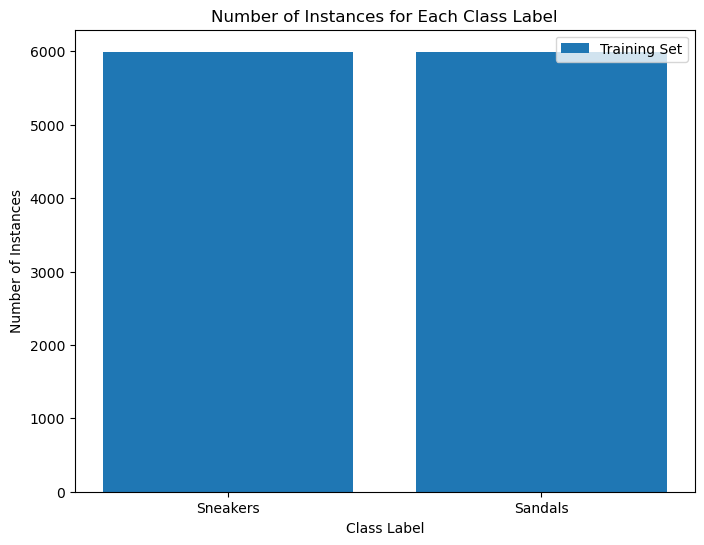

In [3]:
# Get the counts of each class label in the training set and test set
train_label_counts = ss_train['label'].value_counts()

# Plot the number of instances for each class label in the training set
plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts.values, label='Training Set')
plt.xticks([0, 1], ['Sneakers', 'Sandals'])
plt.xlabel('Class Label')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class Label')
plt.legend()
plt.show()

#### D3 Plot first six images from each class

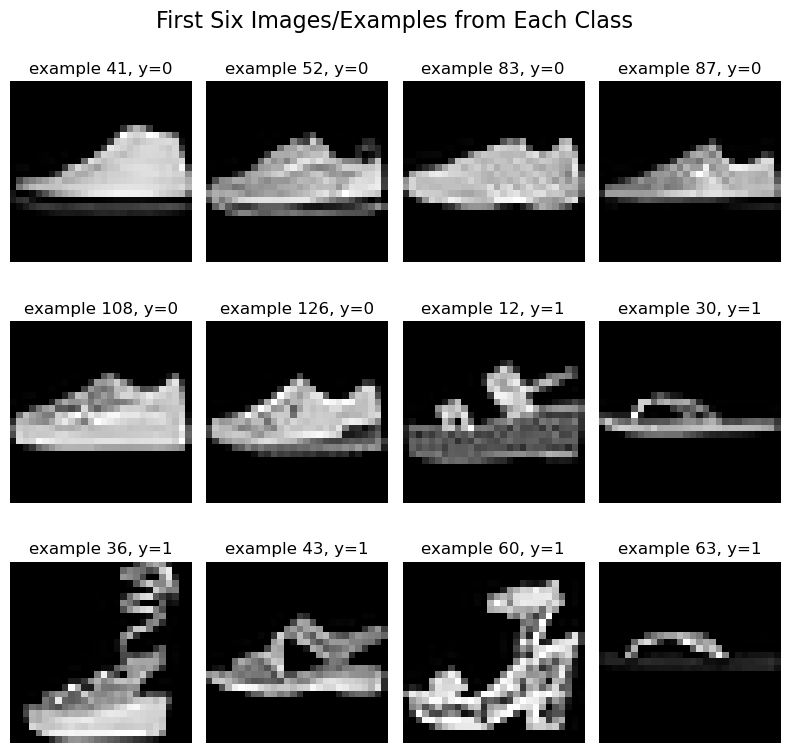

In [4]:
# First six images/examples from each class
sneakers_idx = ss_train_labels[ss_train_labels['label'] == 0].index[:6]
sandals_idx = ss_train_labels[ss_train_labels['label'] == 1].index[:6]
sneakers_images = ss_train_set.loc[sneakers_idx].values.reshape(-1, 28, 28)
sandals_image = ss_train_set.loc[sandals_idx].values.reshape(-1, 28, 28)

# Combine the images into a single array
images = np.concatenate([sneakers_images, sandals_image])
indices = np.concatenate([sneakers_idx, sandals_idx])

# Plot the first six images/examples from each class
fig, axs = plt.subplots(3, 4, figsize=(8, 8))
plt.suptitle('First Six Images/Examples from Each Class', fontsize=16)
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"example {indices[i]}, y={ss_train_labels.loc[indices[i]]['label']}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### 4.2 Fitting your Logistic Regression Classifier (LRC)

In [20]:
# Split the training set into training and validation sets
np.random.seed(5508)
training_data, validation_data = train_test_split(ss_train, test_size=0.2, random_state=5508)
train_x, train_y = training_data.drop('label', axis=1), training_data['label']
valid_x, valid_y = validation_data.drop('label', axis=1), validation_data['label']
train_x_bias = np.c_[np.ones((len(train_x), 1)), train_x]
valid_x_bias = np.c_[np.ones((len(valid_x), 1)), valid_x]

2283     0
46566    1
18905    0
39567    1
47292    1
        ..
46550    0
49586    0
50903    1
49336    0
49564    0
Name: label, Length: 9590, dtype: int64


#### Implementation of the LRC with Batch Gradient Descent

In [6]:
# Predict function
def predict(theta, X):
    h = sigmoid(np.dot(X, theta))
    y_pred = np.where(h >= 0.5, 1, 0)
    return y_pred

# Gradient Descent function
def lr1_gradient_descent(theta, X, y, learning_rate, num_iterations, flag=False):
    m = len(y)
    train_costs, valid_costs, train_rates, valid_rates = [], [], [], []
    for i in range(num_iterations):
        # calculate the gradient vector using all instances
        gradients = 1/m * np.dot(X.T, sigmoid(np.dot(X, theta)) - y)
        # update the parameter vector
        theta -= learning_rate * gradients
        # compute the estimated probability for each instance
        est_p = sigmoid(X.dot(theta))
        est_p_val = sigmoid(valid_x_bias.dot(theta))
        
        # calculate the cost function for the training and validation sets
        lr_cost_train = log_loss(y, est_p)
        lr_cost_val = log_loss(valid_y, est_p_val)
        train_costs.append(lr_cost_train)
        valid_costs.append(lr_cost_val)
        
        # Calculate the misclassification rate for the training and validation sets
        y_pred_train = np.where(est_p >= 0.5, 1, 0)
        y_pred_val = np.where(est_p_val >= 0.5, 1, 0)
        misclass_rate_train = np.mean(y_pred_train != y)
        misclass_rate_val = np.mean(y_pred_val != valid_y)
        train_rates.append(misclass_rate_train)
        valid_rates.append(misclass_rate_val)
        
        # Print cost and misclassification rate every 1000 iterations
        if (i % 1000 == 0) and flag:
            print_cost = round(lr_cost_train, 4)
            print_rate = round(misclass_rate_train, 4)
            print(f"Iteration {i}:\t\tCost: {print_cost}\tRate: {print_rate}")
            
        # Print only the start and final cost and misclassification rate
        if (i == 0 or i == 9999) and not flag:
            print_cost = round(lr_cost_train, 4)
            print_rate = round(misclass_rate_train, 4)
            print(f"Start:\t\t\tCost: {print_cost}\tRate: {print_rate}")
    
    return theta, train_costs, valid_costs, train_rates, valid_rates

#### Train the logistic regression classifier with 10000 iterations

Iteration 0:		Cost: 23.8015	Rate: 0.6658
Iteration 1000:		Cost: 15.1822	Rate: 0.4286
Iteration 2000:		Cost: 12.2491	Rate: 0.3469
Iteration 3000:		Cost: 10.8543	Rate: 0.3078
Iteration 4000:		Cost: 9.9102	Rate: 0.2819
Iteration 5000:		Cost: 9.1475	Rate: 0.2605
Iteration 6000:		Cost: 8.4839	Rate: 0.2415
Iteration 7000:		Cost: 7.9581	Rate: 0.2261
Iteration 8000:		Cost: 7.5088	Rate: 0.2138
Iteration 9000:		Cost: 7.1163	Rate: 0.2036
Iteration 10000:	Cost: 6.7754	Rate: 0.1942
Accuracy: 0.8153


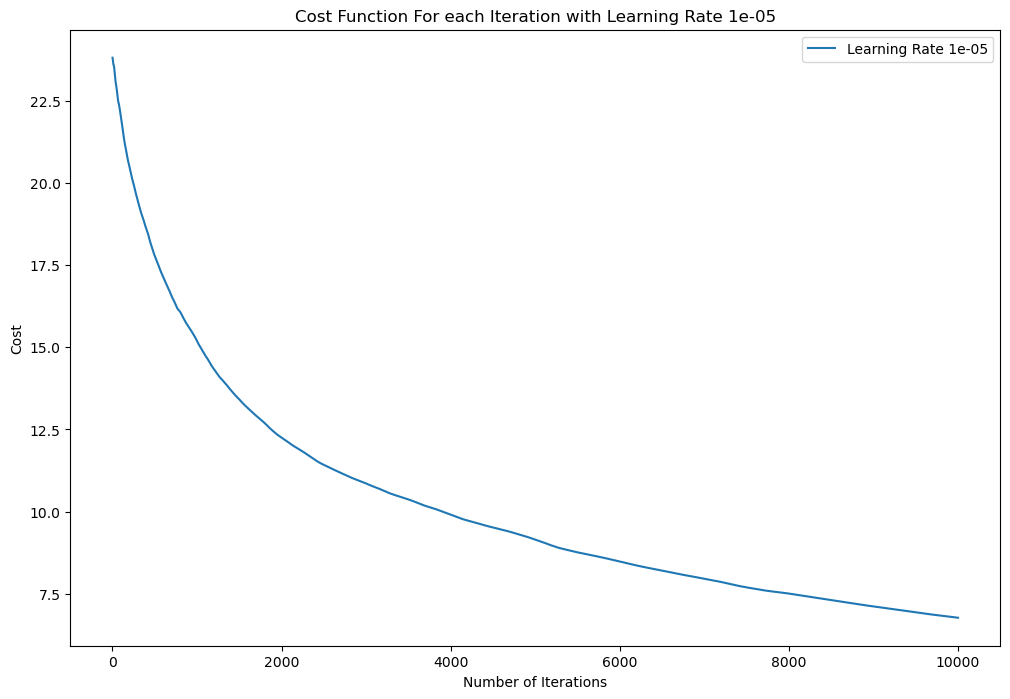

In [10]:

# Initialize the parameters
num_iterations = 10000
learning_rate = 1e-5
theta = np.random.randn(train_x_bias.shape[1])

# Train the logistic regression model
theta_lr1, d5_tcosts, d5_vcosts, d5_trates, d5_vrates = lr1_gradient_descent(theta, train_x_bias, train_y, learning_rate, num_iterations, flag=True)

# Calculate the accuracy of the model
y_pred_lr1 = predict(theta_lr1, valid_x_bias)
accuracy = accuracy_score(valid_y, y_pred_lr1)
print_cost, print_rate = round(d5_tcosts[-1], 4), round(d5_trates[-1], 4)
print(f"Iteration {num_iterations}:\tCost: {print_cost}\tRate: {print_rate}")
print('Accuracy:', round(accuracy, 4))

# Plot the cost function for the training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_iterations + 1), d5_tcosts, label=f'Learning Rate {learning_rate}')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title(f'Cost Function For each Iteration with Learning Rate {learning_rate}')
plt.legend()
plt.show()

#### D4 Experiment with different learning rates

Start:			Cost: 18.0106	Rate: 0.4997
Start:			Cost: 1.2538	Rate: 0.0349
Start:			Cost: 10.9687	Rate: 0.3111
Start:			Cost: 0.9618	Rate: 0.0275
Start:			Cost: 14.9041	Rate: 0.4184
Start:			Cost: 1.2281	Rate: 0.0439
Start:			Cost: 12.3617	Rate: 0.3484
Start:			Cost: 2.5545	Rate: 0.0749
Start:			Cost: 23.3002	Rate: 0.6502
Start:			Cost: 6.8045	Rate: 0.1945
Start:			Cost: 17.26	Rate: 0.4795
Start:			Cost: 13.7896	Rate: 0.3892


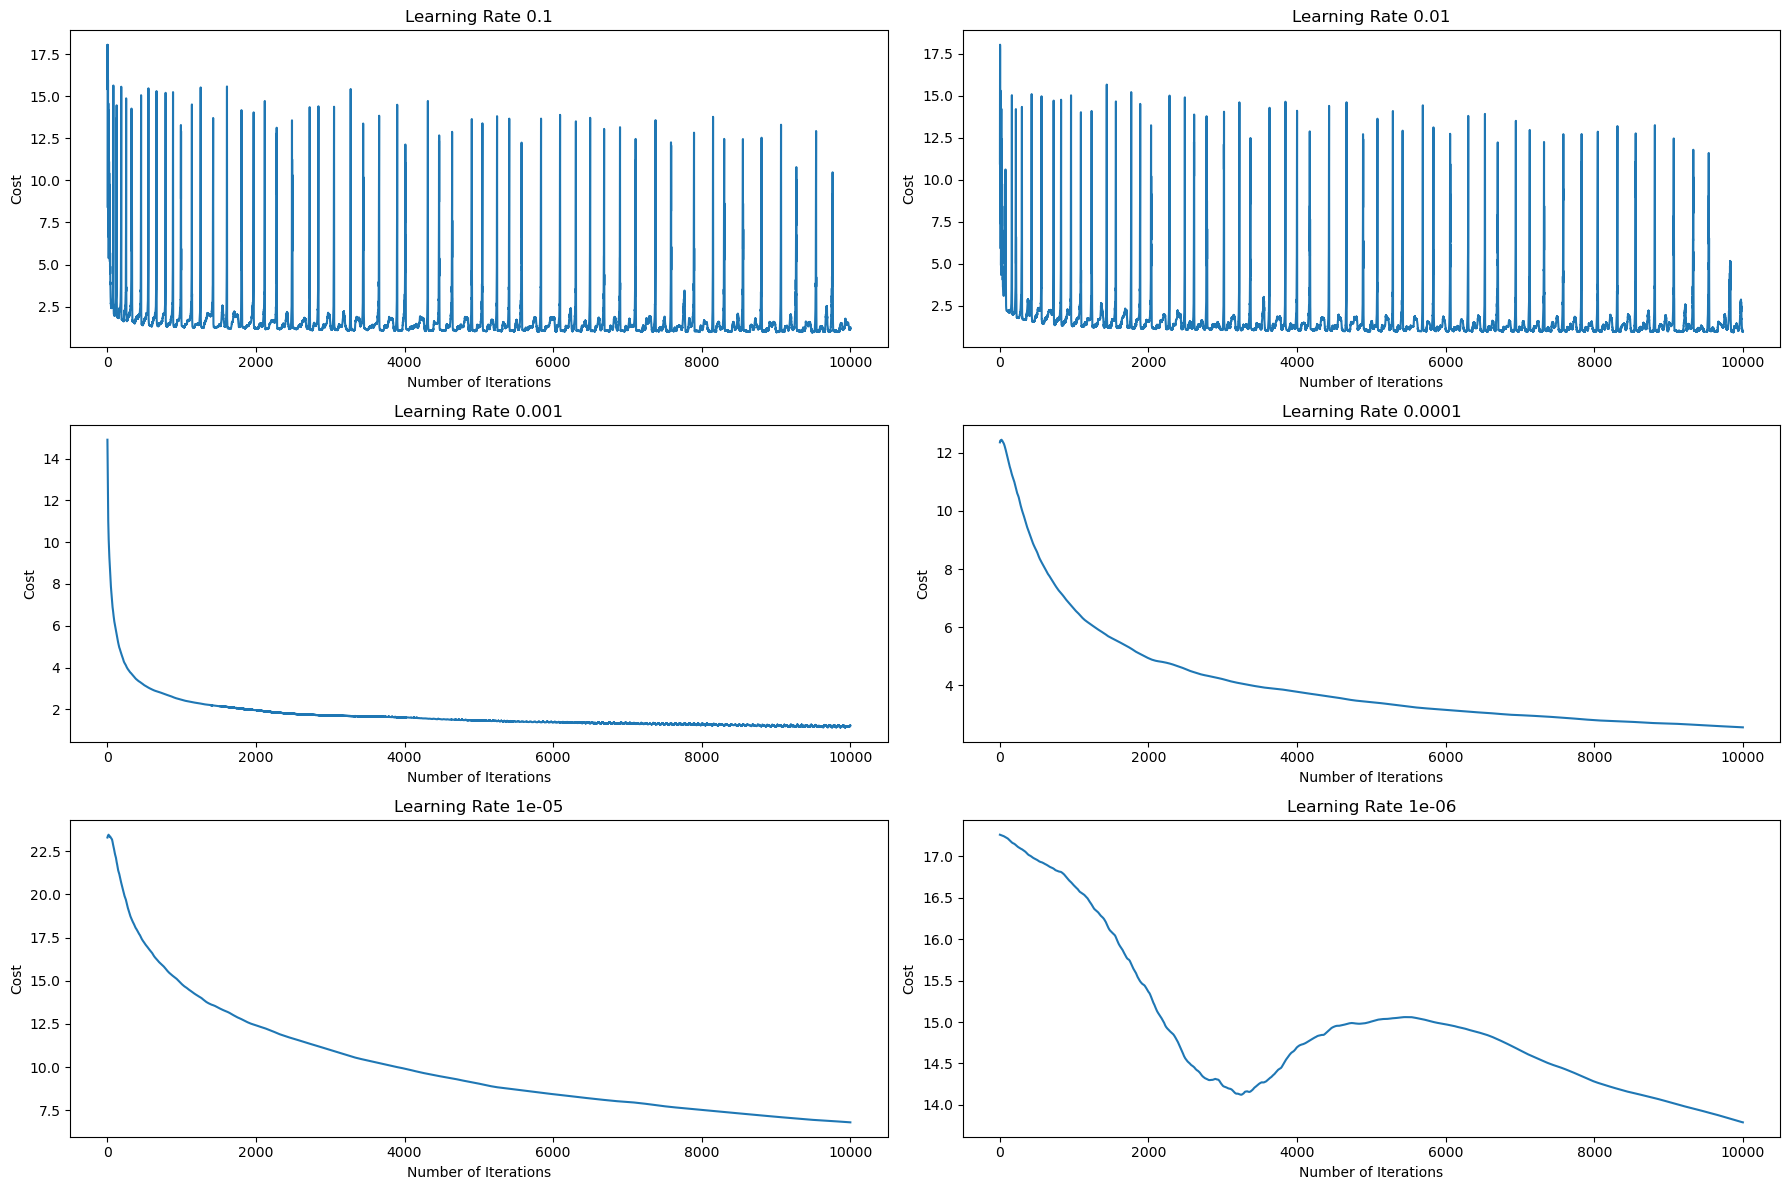

In [13]:
# Plot the cost history for the training sets using different learning rates
plt.figure(figsize=(18, 12))

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
num_iterations = 10000
for i, lr in enumerate(learning_rates):
    theta = np.random.randn(train_x_bias.shape[1])
    _, d4_costs, _, _, _ = lr1_gradient_descent(theta, train_x_bias, train_y, lr, num_iterations)
    plt.subplot(3, 2, i+1)
    plt.plot(range(1, num_iterations + 1), d4_costs, label=f'Learning Rate {lr}')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cost')
    plt.title(f'Learning Rate {lr}')

plt.tight_layout()
plt.show()

#### D5 Plot the cost function and the fraction of misclassifications for each iteration, using learning rate of 1e-5

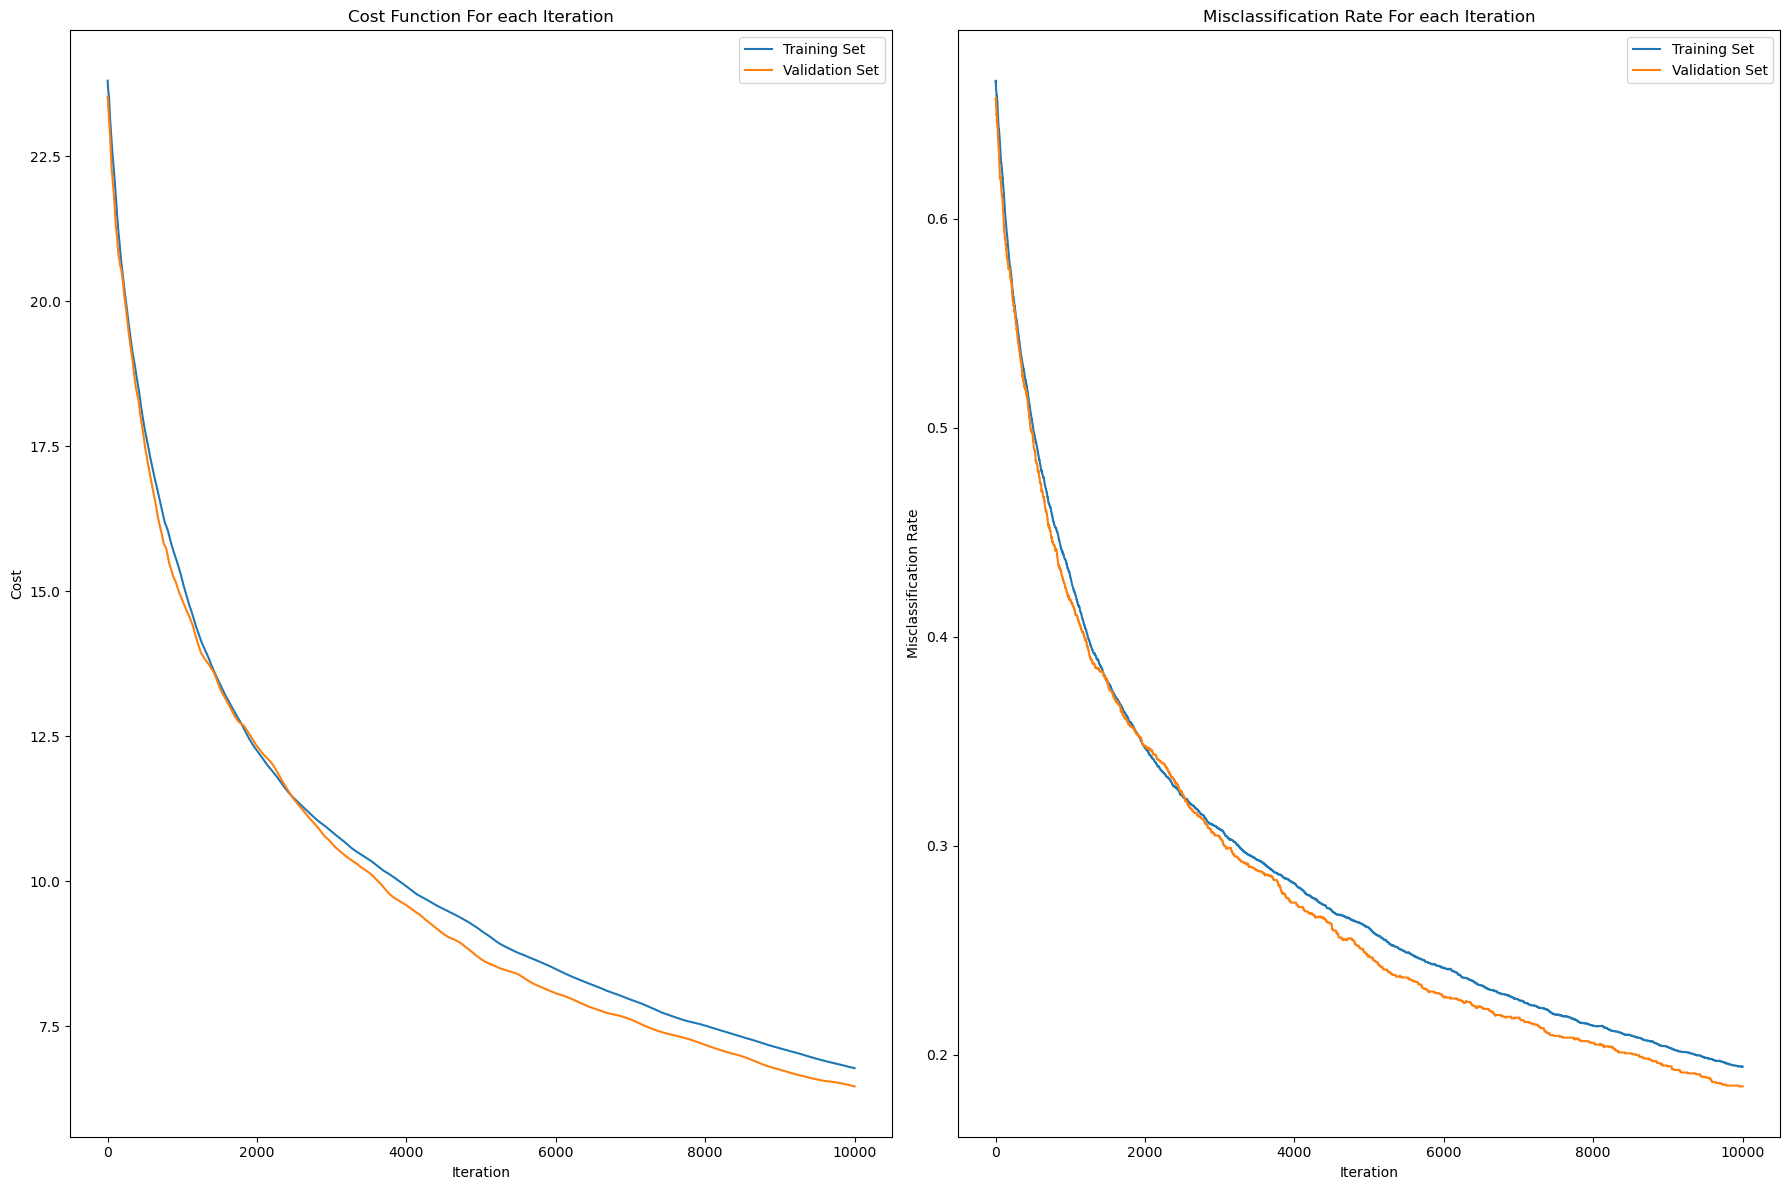

In [11]:
# Plot the cost function and misclassification rate for each iteration
fig, axs = plt.subplots(1, 2, figsize=(18, 12))

# Left plot: Cost function for each iteration
axs[0].plot(range(1, num_iterations + 1), d5_tcosts, label='Training Set')
axs[0].plot(range(1, num_iterations + 1), d5_vcosts, label='Validation Set')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Function For each Iteration')
axs[0].legend()

# Right plot: Misclassification rate for each iteration
axs[1].plot(range(1, num_iterations + 1), d5_trates, label='Training Set')
axs[1].plot(range(1, num_iterations + 1), d5_vrates, label='Validation Set')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate For each Iteration')
axs[1].legend()

plt.tight_layout()
plt.show()

#### D6 Interpretation of the above results

### 4.3 Using cross-validation and Scikit-learn LRC
#### Incorporate L2 regularisation in the LRC model

In [12]:
# Gradient Descent function with L2 regularization
def lr2_gradient_descent(theta, X, y, learning_rate, num_iterations, C):
    m = len(y)
    for i in range(num_iterations):
        initial_est_p = sigmoid(X.dot(theta))
        # L2 regularisation term gradient
        gradients = (1/m * X.T.dot(initial_est_p - y)) + (C / m) * np.concatenate(([0], theta[1:]))
        theta -= learning_rate * gradients
    return theta

#### Select the optimal regularisation parameter C

In [11]:
num_iterations = 10000
learning_rate = 1e-5

C_range = np.logspace(-10, 5, 30)
best_C = None
best_cost = float('inf')
theta_lr2 = None
d7_tcosts, d7_vcosts, d7_trates, d7_vrates = [], [], [], []

for C in C_range:
    theta = np.random.randn(train_x_bias.shape[1])
    d7_theta = lr2_gradient_descent(theta, train_x_bias, train_y, learning_rate, num_iterations, C)
    
    # Calculate the costs and misclassification rates
    est_p_train = sigmoid(train_x_bias.dot(d7_theta))
    est_p_val = sigmoid(valid_x_bias.dot(d7_theta))
    d7_tcosts.append(log_loss(train_y, est_p_train))
    d7_vcosts.append(log_loss(valid_y, est_p_val))
    d7_trates.append(np.mean(predict(d7_theta, train_x_bias) != train_y))
    d7_vrates.append(np.mean(predict(d7_theta, valid_x_bias) != valid_y))

    if d7_vcosts[-1] < best_cost:
        best_cost = d7_vcosts[-1]
        best_C = C
        theta_lr2 = d7_theta
    
    print_cost = round(log_loss(train_y, est_p_train), 4)
    print_rate = round(np.mean(predict(theta, train_x_bias) != train_y), 4)
    print(f"C-value: {C}\tCost: {print_cost}\tRate: {print_rate}")
        
print("Best C value:", best_C)

C-value: 1e-10	Cost: 6.9678	Rate: 0.1985
C-value: 3.290344562312671e-10	Cost: 7.2864	Rate: 0.2075
C-value: 1.0826367338740564e-09	Cost: 6.2141	Rate: 0.177
C-value: 3.5622478902624513e-09	Cost: 6.9163	Rate: 0.1962
C-value: 1.1721022975334793e-08	Cost: 5.4039	Rate: 0.1546
C-value: 3.8566204211634724e-08	Cost: 6.1394	Rate: 0.1752
C-value: 1.2689610031679235e-07	Cost: 6.1751	Rate: 0.1771
C-value: 4.175318936560409e-07	Cost: 6.6816	Rate: 0.191
C-value: 1.3738237958832638e-06	Cost: 5.7212	Rate: 0.1635
C-value: 4.5203536563602494e-06	Cost: 5.9346	Rate: 0.1696
C-value: 1.4873521072935119e-05	Cost: 7.0308	Rate: 0.1998
C-value: 4.893900918477499e-05	Cost: 6.6236	Rate: 0.1897
C-value: 0.00016102620275609426	Cost: 6.1967	Rate: 0.1771
C-value: 0.0005298316906283713	Cost: 6.9563	Rate: 0.1986
C-value: 0.0017433288221999908	Cost: 5.6778	Rate: 0.1619
C-value: 0.005736152510448681	Cost: 6.2599	Rate: 0.1787
C-value: 0.018873918221350997	Cost: 6.5046	Rate: 0.1861
C-value: 0.06210169418915629	Cost: 6.5637	

#### D7 Plot the cost function and the fraction of misclassification for each C value

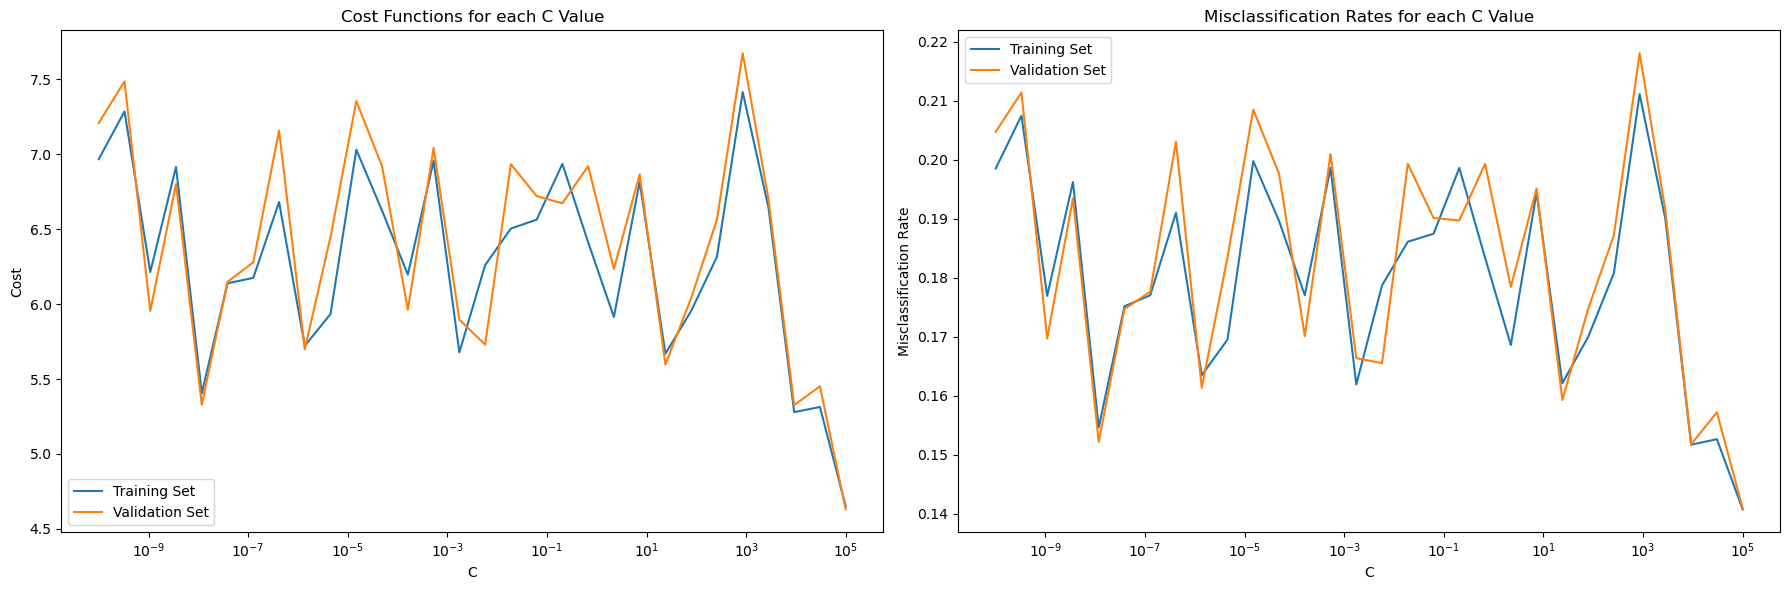

In [12]:
# Plot the cost function and misclassification rate for each C value
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Cost function for each C value
axs[0].plot(C_range, d7_tcosts, label='Training Set')
axs[0].plot(C_range, d7_vcosts, label='Validation Set')
axs[0].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Functions for each C Value')
axs[0].legend()

# Right plot: Misclassification rate for each C value
axs[1].plot(C_range, d7_trates, label='Training Set')
axs[1].plot(C_range, d7_vrates, label='Validation Set')
axs[1].set_xscale('log')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rates for each C Value')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Using Scikit-learn LogicticRegressionCV with 10-fold cross-validation

In [26]:
# Create a logistic regression model with 10-fold cross-validation
C_range = np.logspace(-10, 5, 30)
lr3_model = LogisticRegressionCV(Cs=C_range, cv=10, penalty='l2', solver='sag', max_iter=10000, random_state=5508)
full_train_x = ss_train_set
full_train_y = ss_train_labels.values.ravel()
lr3_model.fit(full_train_x, full_train_y)

# Print the best C value
print('Best C value:', lr3_model.C_)
print('Accuracy:', lr3_model.score(valid_x, valid_y))

# Get the average cost function value and fraction of misclassifications for each C value
d8_costs = np.mean(lr3_model.scores_[1], axis=0)
d8_rates = np.mean(1 - lr3_model.scores_[1], axis=0)

#### D8 Plot the average cost function and the fraction of misclassification for each C value

In [ ]:
# Plot the average cost function and misclassification rate for each C value
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Average cost function for each C value
axs[0].plot(C_range, d8_costs, label='Average Cost')
axs[0].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Average Cost')
axs[0].set_title('Average Cost Function for each C Value')
axs[0].legend()

# Right plot: Misclassification rate for each C value
axs[1].plot(C_range, d8_rates, label='Misclassification Rate')
axs[1].set_xscale('log')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for each C Value')
axs[1].legend()

plt.tight_layout()
plt.show()

#### D9 Interpretation of the above results

Which regularisation hyperparameter value would you select and why?
What was the impact of using 10-fold cross-validation instead of a fixed validation set?

#### D10 Using SGDClassifier with GridSearchCV to find the optimal hyperparameters

In [13]:
# Create SGDClassifier model
sgd = SGDClassifier(loss='log_loss', penalty='l2', random_state=5508)

# Create an instance of GridSearchCV with 10-fold cross-validation
C_range = np.logspace(-10, 5, 30)
grid_search = GridSearchCV(estimator=sgd, param_grid={'alpha': C_range}, cv=10, scoring='neg_log_loss')
grid_search.fit(train_x, train_y)

# Get the optimal C value
optimal_C = grid_search.best_params_['alpha']

# Get the training and validation log loss scores
train_score = -grid_search.best_score_
val_score = -grid_search.score(valid_x, valid_y)

# Get the training and validation misclassification rates
train_pred = grid_search.predict(train_x)
val_pred = grid_search.predict(valid_x)
train_misclass = 1 - accuracy_score(train_y, train_pred)
val_misclass = 1 - accuracy_score(valid_y, val_pred)

# Print the results
data = {'Optimal C': [optimal_C],
        'Training Cost Function': [train_score],
        'Validation Cost Function': [val_score],
        'Training Misclassifications': [train_misclass],
        'Validation Misclassifications': [val_misclass]}

df = pd.DataFrame(data).transpose()
print(df)

                                       0
Optimal C                      23.950266
Training Cost Function          0.124927
Validation Cost Function        0.131889
Training Misclassifications     0.035975
Validation Misclassifications   0.048791


#### D11 Interpretation of the above results

How do they compare with what you obtain in task D8?

#### D12 Select and train the Logistic Regression model with the optimal C value

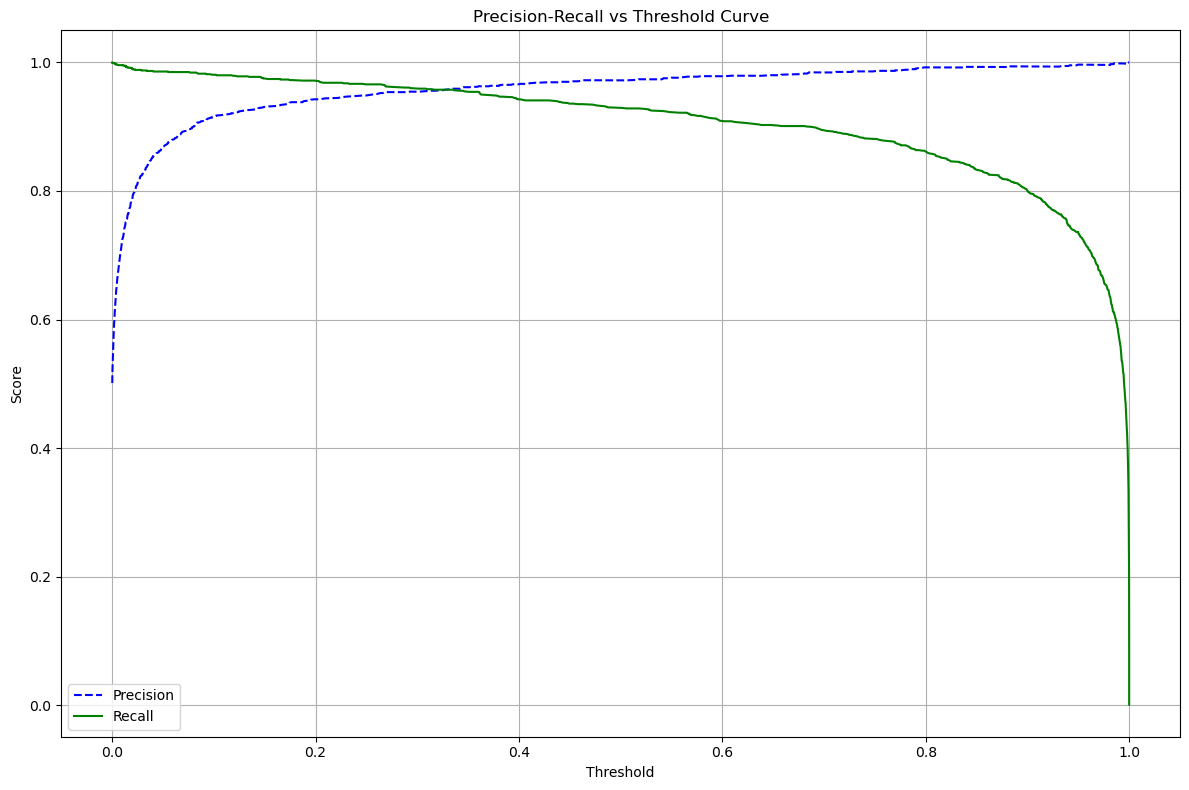

In [14]:
# Train the model using the optimal C value
lr_model = SGDClassifier(loss='log_loss', penalty='l2', alpha=optimal_C, random_state=5508)
lr_model.fit(train_x, train_y)
y_prob_val = lr_model.predict_proba(valid_x)[:, 1]

# Calculate the precision and recall for different threshold values
precision, recall, thresholds = precision_recall_curve(valid_y, y_prob_val)

# Plot the precision and recall versus different threshold values
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### D13 Fine-tune the optimal threshold value using Grid Search

In [15]:
# Initialise variables
thresholds = np.linspace(0, 1, 100)
best_threshold = None
best_f1_score = 0

# Find the threshold that maximizes the F1 score
for threshold in thresholds:
    y_pred_val = (y_prob_val >= threshold).astype(int)
    f1 = f1_score(valid_y, y_pred_val)
    if f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

print('Best threshold:\t', best_threshold)
print('Best F1 score:\t', best_f1_score)

Best threshold:	 0.26262626262626265
Best F1 score:	 0.9591078066914498


### 4.4 Analysing the performance closer
#### D14 Print the confusion matrix, precision, recall, and false positive rate for each model
- **LR1**: The model in 4.2, which is your implementation of the logistic regression without regularisation and with a fixed validation set.
- **LR2**: The model in 4.3, which is your implementation of the logistic regression with regularisation and with a fixed validation set.
- **LR3**: The the model in 4.3 using 10-fold cross-validation and the optimal value of the regularisation hyperparameter C according to Grid Search but keeping the threshold value for the logistic regression prediction model at 0.5.
- **LR4**: The model in 4.3 using 10-fold cross-validation and the optimal value of the regularisation hyperparameter C according to Grid Search and threshold values according to your grid search in D13.

In [ ]:
# Function to calculate precision, recall, and false positive rate
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    fpr = fp / (fp + tn)
    return cm, precision, recall, fpr

# Function to evaluate each model
def evaluate_model(model, X, y, threshold=0.5):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = y_prob >= threshold
    cm, precision, recall, fpr = calculate_metrics(y, y_pred)
    return cm, precision, recall, fpr

def print_confusion_matrix(cm):
    predicted = ['Predicted Positive', 'Predicted Negative']
    actual = ['Actual Positive', 'Actual Negative']
    df_cm = pd.DataFrame(cm.T, index=predicted, columns=actual)
    print(df_cm)

In [55]:
# Evaluate LR1, LR2, LR3, and LR4 models on the test set
test_x, test_y = ss_test_set, ss_test_labels['label']
test_x_bias = np.c_[np.ones((len(test_x), 1)), test_x]

# Get the predictions for each model
y_pred_lr1 = predict(theta_lr1, test_x_bias)
y_pred_lr2 = predict(theta_lr2, test_x_bias)
y_prob = lr_model.predict_proba(test_x)[:, 1]
y_pred_lr3 = (y_prob >= 0.5).astype(int)
y_pred_lr4 = (y_prob >= best_threshold).astype(int)
y_pred_models = [y_pred_lr1, y_pred_lr2, y_pred_lr3, y_pred_lr4]

print('====================================================')
for i, y_pred in enumerate(y_pred_models):
    cm, precision, recall, fpr = calculate_metrics(test_y, y_pred)

    # Print the results
    print(f'Logistic Regression Model {i+1}')
    print('Confusion Matrix:')
    print_confusion_matrix(cm)
    print('Precision:', precision)
    print('Recall:', recall)
    print('False Positive Rate:', fpr)
    print('====================================================')

Logistic Regression Model 1
Confusion Matrix:
Precision: 0.8362068965517241
Recall: 0.776
False Positive Rate: 0.152
Logistic Regression Model 2
Confusion Matrix:
Precision: 0.8737166324435318
Recall: 0.851
False Positive Rate: 0.123
Logistic Regression Model 3
Confusion Matrix:
Precision: 0.9737394957983193
Recall: 0.927
False Positive Rate: 0.025
Logistic Regression Model 4
Confusion Matrix:
Precision: 0.9486673247778875
Recall: 0.961
False Positive Rate: 0.052


#### D15 Interpretation of the above results

Discuss generalisation capacity of the four models.

#### D16 Show 5 images that are false positives and false negatives on the test sets for model LR4

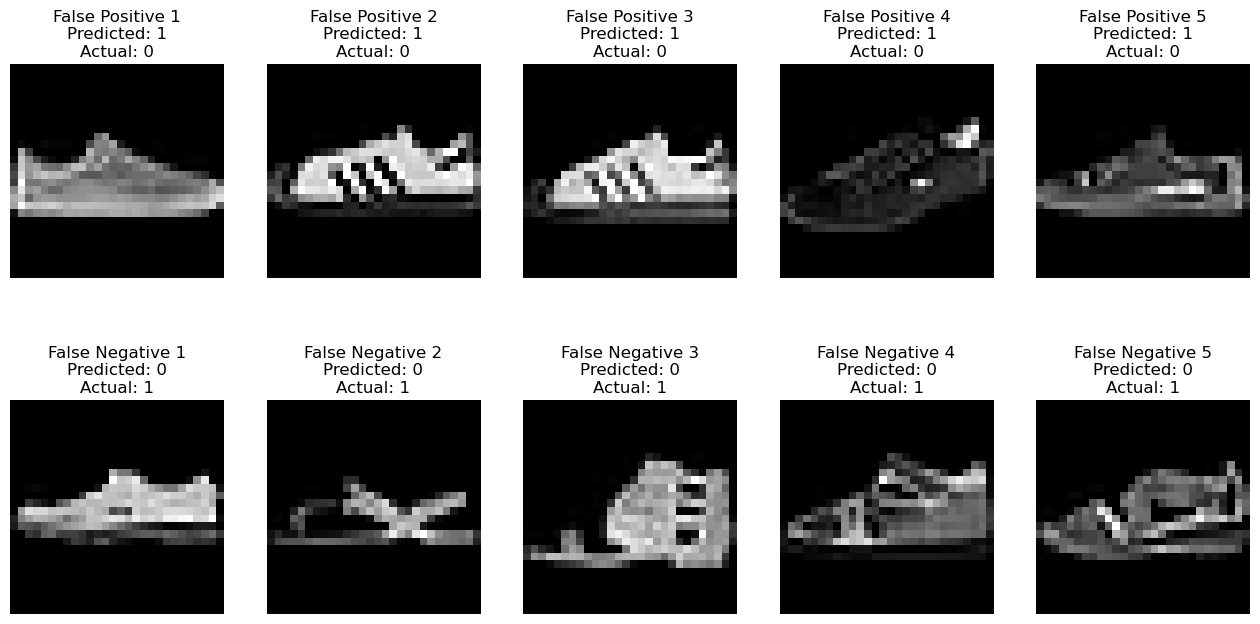

In [42]:
# Find the indices of false positives and false negatives
fp_idx = np.where((y_pred_lr4 == 1) & (test_y.values == 0))[0]
fn_idx = np.where((y_pred_lr4 == 0) & (test_y.values == 1))[0]

fig, axs = plt.subplots(2, 5, figsize=(16, 8))

# Plot 5 false positives
for i, idx in enumerate(fp_idx[:5]):
    fp_img = test_x.iloc[idx].values.reshape(28, 28)
    predicted = y_pred_lr4[idx]
    actual = test_y.iloc[idx]
    axs[0, i].imshow(fp_img, cmap='gray')
    axs[0, i].set_title(f'False Positive {i+1}\nPredicted: {predicted}\nActual: {actual}')
    axs[0, i].axis('off')

# Plot 5 false negatives
for i, idx in enumerate(fn_idx[:5]):
    fn_img = test_x.iloc[idx].values.reshape(28, 28)
    predicted = y_pred_lr4[idx]
    actual = test_y.iloc[idx]
    axs[1, i].imshow(fn_img, cmap='gray')
    axs[1, i].set_title(f'False Negative {i+1}\nPredicted: {predicted}\nActual: {actual}')
    axs[1, i].axis('off')

plt.show()

#### D17 Interpretation of the above results

Describe what kinds of mistakes the model is making?

#### D18 LR4's parameter values

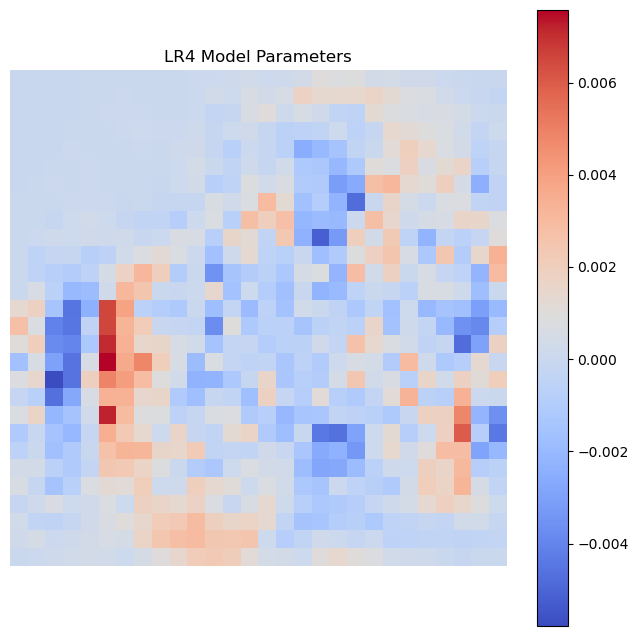

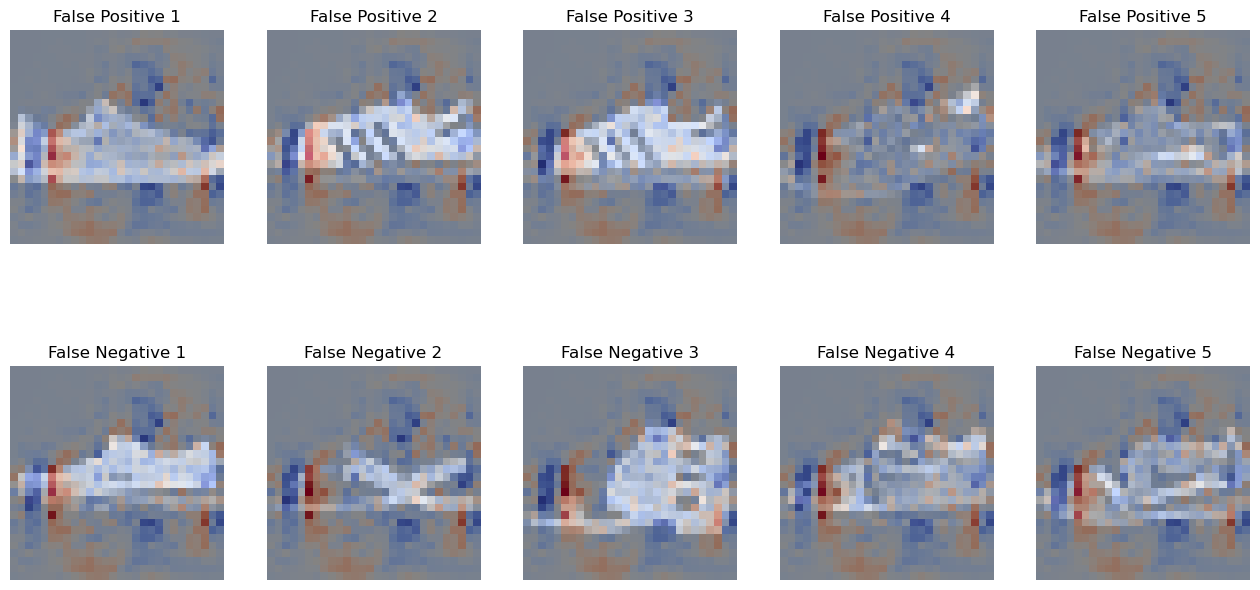

In [40]:
# Reshape the parameters of LR4 into a 28x28 matrix
weights = lr_model.coef_[0]
weight_matrix = weights.reshape(28, 28)

# Plot the coefficients
plt.figure(figsize=(8, 8))
plt.imshow(weight_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('LR4 Model Parameters')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(16, 8))

# Plot the weights associated with false positives
for i, idx in enumerate(fp_idx[:5]):
    fp_img = test_x.iloc[idx].values.reshape(28, 28)
    axs[0, i].imshow(fp_img, cmap='gray')
    axs[0, i].set_title(f'False Positive {i+1}')
    axs[0, i].axis('off')
    axs[0, i].imshow(weight_matrix, cmap='coolwarm', alpha=0.6)

# Plot the weights associated with false negatives
for i, idx in enumerate(fn_idx[:5]):
    fn_img = test_x.iloc[idx].values.reshape(28, 28)
    axs[1, i].imshow(fn_img, cmap='gray')
    axs[1, i].set_title(f'False Negative {i+1}')
    axs[1, i].axis('off')
    axs[1, i].imshow(weight_matrix, cmap='coolwarm', alpha=0.6)

plt.show()

#### D19 Interpretation of the above results

Comment

#### k-Nearest Neighbours (k-NN) Classifier
#### D20 Plot the fraction of misclassification for each k value

1	0.0	0.048	1.0	0.952
2	0.046	0.081	0.954	0.919
3	0.029	0.054	0.971	0.946
4	0.056	0.073	0.944	0.927
5	0.044	0.062	0.956	0.938
6	0.063	0.071	0.937	0.929
7	0.054	0.065	0.946	0.935
8	0.065	0.074	0.935	0.926
9	0.059	0.068	0.941	0.932
10	0.068	0.075	0.932	0.925
11	0.063	0.072	0.937	0.928
12	0.07	0.077	0.93	0.923
13	0.065	0.071	0.935	0.929
14	0.072	0.079	0.928	0.921
15	0.067	0.073	0.933	0.927
16	0.073	0.079	0.927	0.921
17	0.069	0.075	0.931	0.925
18	0.075	0.081	0.925	0.919
19	0.072	0.078	0.928	0.922
20	0.076	0.083	0.924	0.917
21	0.073	0.081	0.927	0.919
22	0.078	0.084	0.922	0.916
23	0.075	0.083	0.925	0.917
24	0.079	0.085	0.921	0.915
25	0.077	0.084	0.923	0.916
26	0.08	0.086	0.92	0.914
27	0.079	0.083	0.921	0.917
28	0.082	0.086	0.918	0.914
29	0.08	0.084	0.92	0.916
30	0.082	0.088	0.918	0.912
Best k value: 1
Best accuracy: 0.9520433694745621


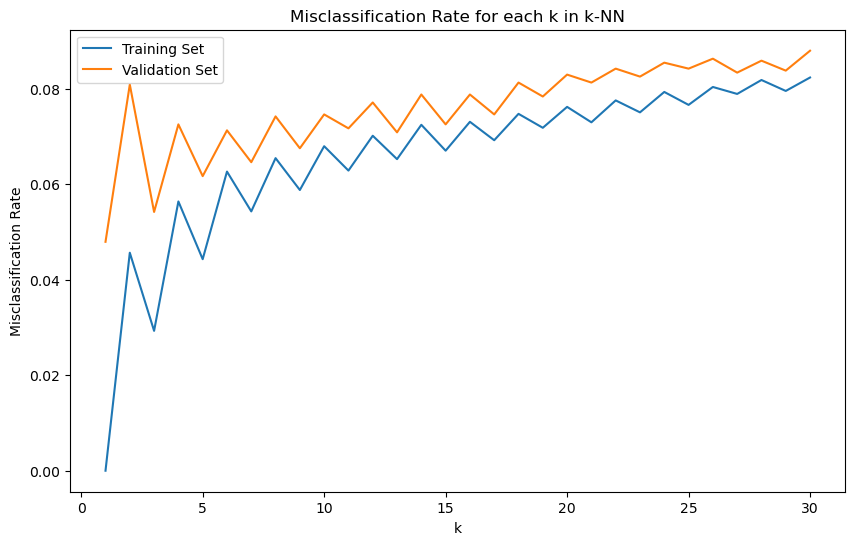

In [7]:
k_values = range(1,31)
best_k = None
best_accuracy = 0
d20_trates, d20_vrates = [], []

# Try for different k values
for k in k_values:
    # Create and train the k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, train_y)
    
    # Predict labels for training set
    train_pred = knn.predict(train_x)
    train_accuracy = accuracy_score(train_y, train_pred)
    train_misclass = 1 - train_accuracy
    d20_trates.append(train_misclass)
    
    # Predict labels for validation set
    valid_pred = knn.predict(valid_x)
    valid_accuracy = accuracy_score(valid_y, valid_pred)
    valid_misclass = 1 - valid_accuracy
    d20_vrates.append(valid_misclass)
    
    print(f"{k}\t{round(train_misclass,3)}\t{round(valid_misclass,3)}\t{round(train_accuracy,3)}\t{round(valid_accuracy,3)}")
    
    # Update the best k and accuracy
    if valid_accuracy > best_accuracy:
        best_k = k
        best_accuracy = valid_accuracy

# Print the best k value and accuracy
print("Best k value:", best_k)
print("Best accuracy:", best_accuracy)

# Plot the misclassification rates for training and validation sets
plt.figure(figsize=(10, 6))
plt.plot(k_values, d20_trates, label='Training Set')
plt.plot(k_values, d20_vrates, label='Validation Set')
plt.xlabel('k')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate for each k in k-NN')
plt.legend()
plt.show()

1	0.944
2	0.916
3	0.94
4	0.923
5	0.937
6	0.925
7	0.936
8	0.925
9	0.934
10	0.925
11	0.932
12	0.924
13	0.929
14	0.922
15	0.928
16	0.921
17	0.925
18	0.919
19	0.924
20	0.919
21	0.923
22	0.918
23	0.922
24	0.918
25	0.921
26	0.917
27	0.92
28	0.915
29	0.919
30	0.915


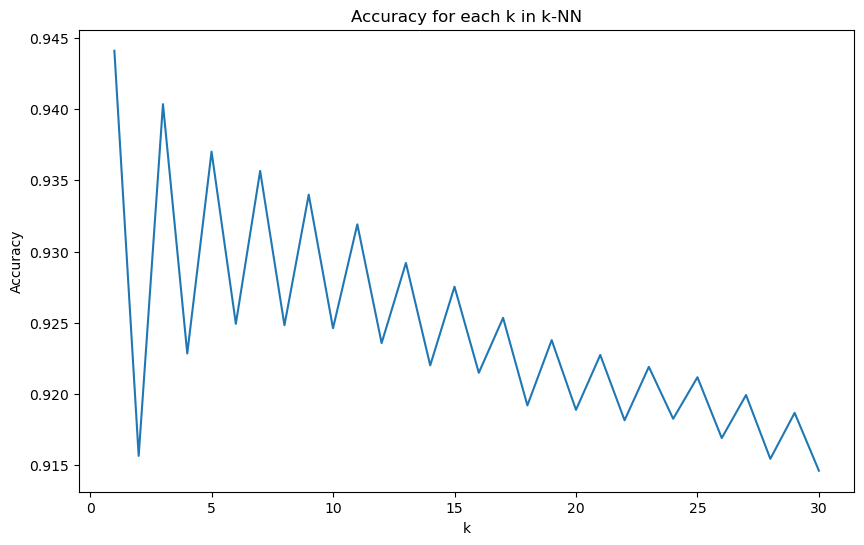

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

k_values = range(1,31)
scores = []
scaler = StandardScaler()
scaled_x = scaler.fit_transform(train_x)

best_k = None
best_accuracy = 0
d20_trates, d20_vrates = [], []

# Try for different k values
for k in k_values:
    # Create and train the k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, scaled_x, train_y, cv=5)
    scores.append(np.mean(score))
    print(f"{k}\t{round(np.mean(score),3)}")
    
# Plot accuracy for each k value
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy for each k in k-NN')
plt.show()

#### D21 Interpretation of the above results

What did you observe as the value of k increases? 
Which value of k would you choose and why? 
How does this model compare with the one you created in section 4.2?

#### D22 Best k-NN performance on the test set

In [17]:
# Create and train the k-NN model with the best k value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(train_x, train_y)

# Predict labels and calculate accuracy for the test set

y_pred_test = best_knn.predict(test_x)
accuracy_test = accuracy_score(test_y, y_pred_test)

# Calculate metrics for k-NN model on the test set
cm, precision, recall, fpr = calculate_metrics(test_y, y_pred_test)

# Print the results
print('================================')
print(f"{best_k}-NN Performance")
print("Accuracy:", accuracy_test)
print("Confusion Matrix:")
print_confusion_matrix(cm)
print("Precision:", precision)
print("Recall:", recall)
print("False Positive Rate:", fpr)
print('================================')

1-NN Performance
Accuracy: 0.9475
Confusion Matrix:
[[996   4]
 [101 899]]
Precision: 0.9955703211517165
Recall: 0.899
False Positive Rate: 0.004


#### D23 Compare k-NN model with the logistic regression models (LR1, LR2, LR3, LR4)

Comment 
Discuss the generaliastion capacity of the different models

### 4.6 Exploring the ML pipeline
#### D24 How to improve the modelling

...